# Sensitivity of Synthetic Data to Modeling Parameters


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from pathlib import Path
home = str(Path.home())
import sys
sys.path.insert(0,"%s/sensitivity_study/src"%home)
from experiment import read_raw_pairwise, construct_support_matrix, get_features_from_support, get_target_stability, eval_models
from sensitivity_tests import *
import utilities

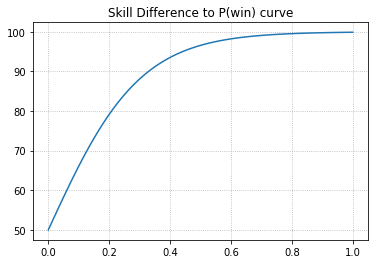

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

ELO_scale = 0.15

xs = np.linspace(0.0, 1.0, endpoint=True, num=100)
ys = sigmoid(xs/ELO_scale)*100.0

plt.grid(True, axis="both", which="both", linestyle=":")
plt.plot(xs, ys)
plt.title("Skill Difference to P(win) curve")
plt.show()

In [4]:
def generate_synth_games(n_games=200, n_teams=32, n_pts=64):
    # Columns are team1, team2, points1, points2, date
    df = {
        "team1":[],
        "team2":[],
        "team1_name":[],
        "team2_name":[],
        "team1_select":[],
        "team2_select":[],
        "team1_score":[],
        "team2_score":[]
    }
    all_teams = range(n_teams)
    all_skills = np.linspace(0.0, 1.0, endpoint=True, num=n_teams)
    for date in range(n_games):
        t1 = date % n_teams
        t2 = t1
        while t2 == t1:
            t2 = random.choice(all_teams)
        scaled_elo_diff = (all_skills[t1] - all_skills[t2])/ELO_scale
        prob_t1_win = sigmoid(scaled_elo_diff)
        t1_pts = n_pts*np.random.binomial(n=1, p=prob_t1_win)
        t2_pts = n_pts - t1_pts
        df["team1"].append(t1)
        df["team2"].append(t2)
        df["team1_name"].append(str(t1))
        df["team2_name"].append(str(t2))
        df["team1_select"].append(1)
        df["team2_select"].append(1)
        df["team1_score"].append(t1_pts)
        df["team2_score"].append(t2_pts)
    return pd.DataFrame(df)

In [5]:
games={}
years = list(range(10))
for year in years:
    games[year] = generate_synth_games()

games[year]

,team1,team2,team1_name,team2_name,team1_select,team2_select,team1_score,team2_score
0,0,20,0,20,1,1,0,64
1,1,23,1,23,1,1,0,64
2,2,25,2,25,1,1,0,64
3,3,9,3,9,1,1,64,0
4,4,25,4,25,1,1,0,64
...,...,...,...,...,...,...,...,...
195,3,26,3,26,1,1,0,64
196,4,5,4,5,1,1,0,64
197,5,23,5,23,1,1,0,64
198,6,9,6,9,1,1,64,0


In [6]:
load = False
# TODO: measure sensitivity of massey & colley to S construction params

config = {
    "col_mapping": {
        "team1_name":"team1_name",
        "team1_score":"team1_score",
        "team2_name":"team2_name",
        "team2_score":"team2_score",
        "team1_select": "team1_select",
        "team2_select": "team2_select",
        "date":"date"
    },
    "rankingMethods": [MasseyRankingAlgorithm(), ColleyRankingAlgorithm()],
    "correlationMethod":utilities.kendall_tau,
    "fracs": [0.5, 0.75, 1.],
    "n_restarts": 5,
    "direct_thres": [0, 1, 2],
    "spread_thres": [0, 1, 2, 3, 4, 5],
    "weight_indirect": [0.25,0.5,0.75,1],
    "raw_filepaths": ["{}/sensitivity_study/data/MarchMadnessDataFrames/march_madness_{}.csv".format(home,yr) for yr in years],
    "model_list": [{"model":DummyRegressor(), "param_grid": {}},
                   {"model":LinearRegression(), "param_grid": {'fit_intercept': [True, False]}}]
}

In [7]:
if load:
    games = {fp: read_raw_pairwise(fp, config["col_mapping"]) for fp in tqdm(config["raw_filepaths"])}

In [8]:
df = {"fp":[], "frac":[], "method":[], "w":[]}
support_matricies = {}
rankings_by_method = {}
feature_df_list = []
# For each raw file (equivalent to a season / tournament / single scenario)
# get feature vector and target scalar
num_matrices = len(games.keys()) * len(config["fracs"]) * len(config["direct_thres"]) \
               * len(config["spread_thres"]) * len(config["weight_indirect"])
with tqdm(total=num_matrices) as pbar:
    for fp in games.keys():
        for frac in config["fracs"]:
            support_matricies[(fp, frac)] = []
            rankings_by_method[(fp, frac)] = {r.__class__.__name__: [] for r in config["rankingMethods"]}

            for d_thresh, s_thresh, w_ind in itertools.product(config["direct_thres"],
                                                               config["spread_thres"],
                                                               config["weight_indirect"]):
                support_mat = construct_support_matrix(games[fp],
                                                       frac,
                                                       direct_thres=d_thresh,
                                                       spread_thres=s_thresh,
                                                       weight_indirect=w_ind)
                support_matricies[(fp, frac)].append(support_mat)
                # get rankings for support for all ranking methods
                for rankingMethod in config["rankingMethods"]:
                    rankings_by_method[(fp, frac)][rankingMethod.__class__.__name__].append(rankingMethod.rank(support_mat.fillna(0).values))
                pbar.update(1)

            for methodName, rankings in rankings_by_method[(fp, frac)].items():
                #df["fp"].append(fp[-8:-4])
                df["fp"].append(fp)
                df["frac"].append(frac)
                df["method"].append(methodName)
                df["w"].append(kendall_w(rankings)[1])

df = pd.DataFrame(df)

100%|██████████| 2160/2160 [04:15<00:00,  8.45it/s]


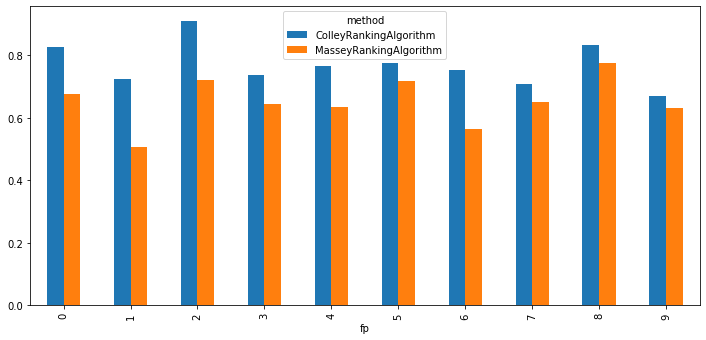

In [9]:
df.groupby(["fp", "method"])["w"].mean().unstack().plot.bar(figsize=(12,5.5))

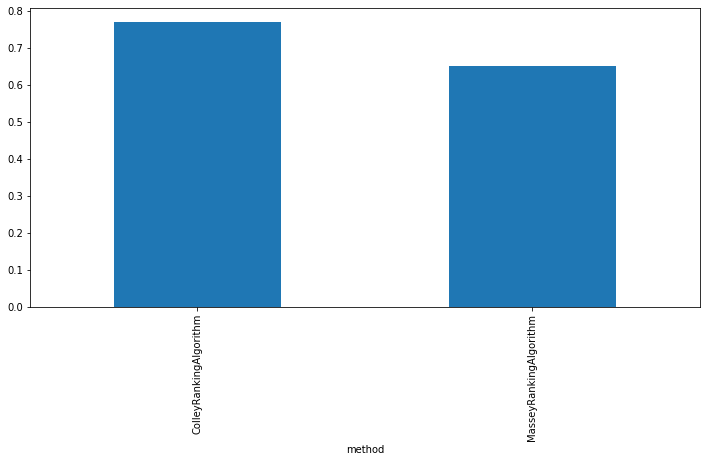

In [14]:
df.groupby(["method"])["w"].mean().plot.bar(figsize=(12,5.5))

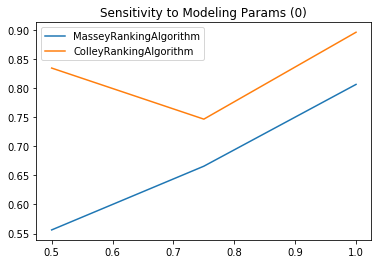

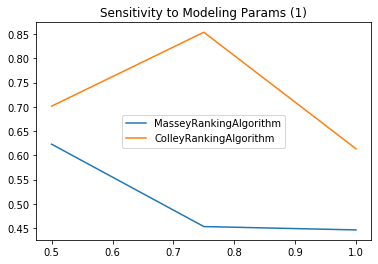

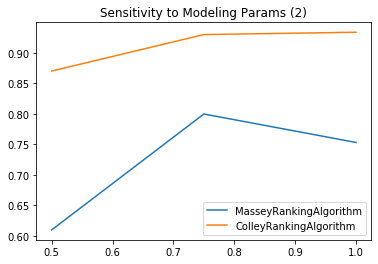

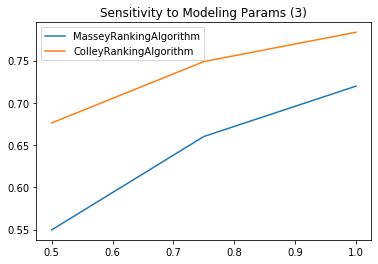

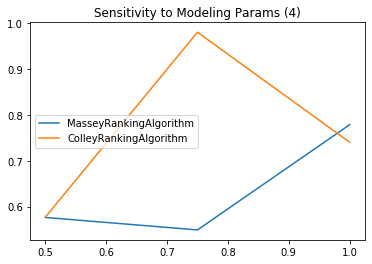

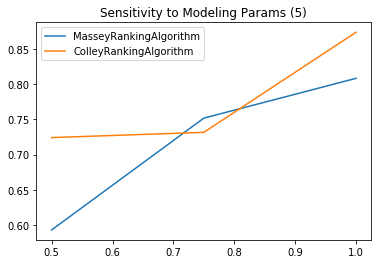

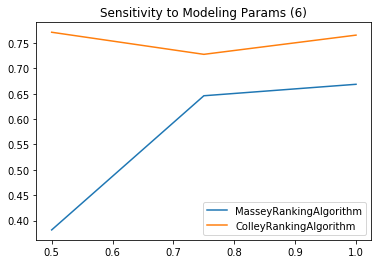

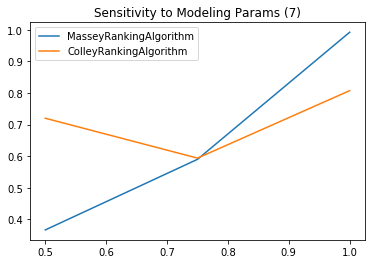

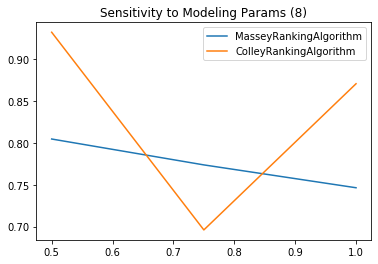

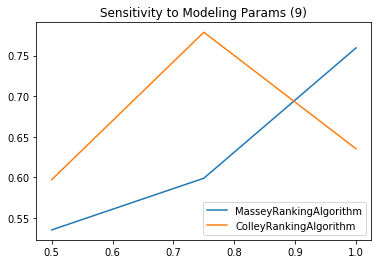

In [10]:
for yr in df["fp"].unique():
    for method in df["method"].unique():
        data = df.loc[(df.fp==yr)&(df.method==method), ["frac", "w"]]
        plt.plot(data.frac, data.w, label=method)
    plt.title("Sensitivity to Modeling Params ({})".format(yr))
    plt.legend()
    plt.show()

In [ ]:
if save:
    df.to_csv("sensitivity_to_modeling_parameters.csv", index=False)

In [11]:
prev_sensitivity = pd.read_csv("sensitivity_to_modeling_parameters.csv")

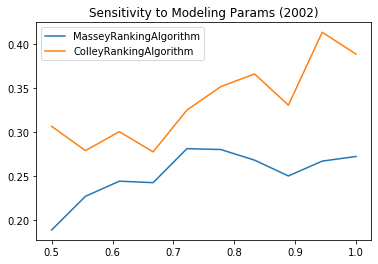

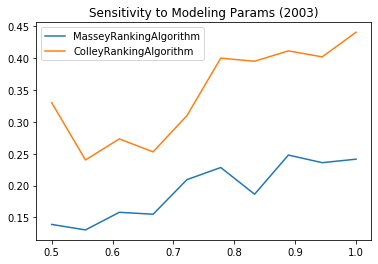

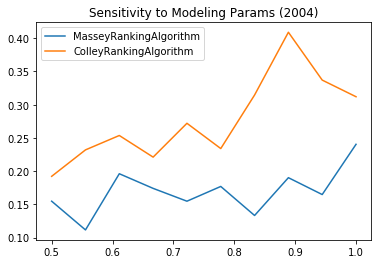

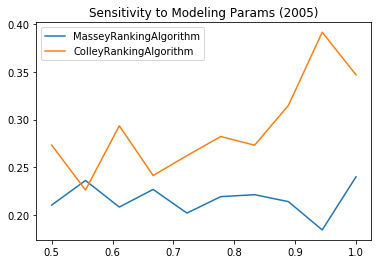

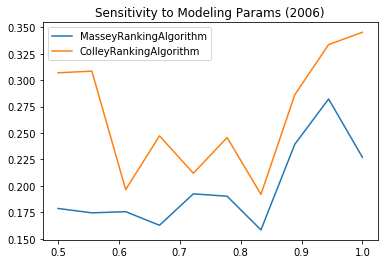

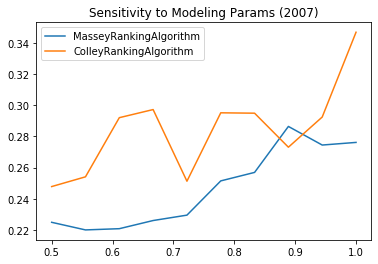

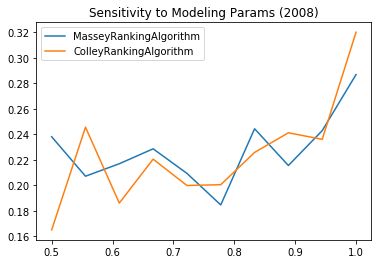

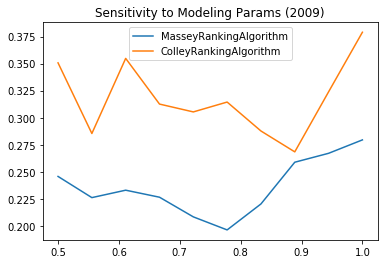

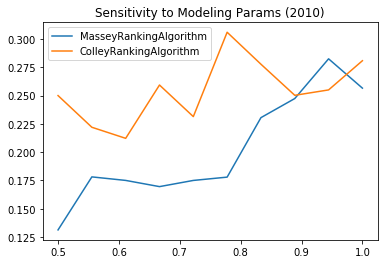

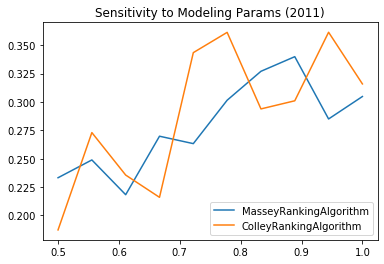

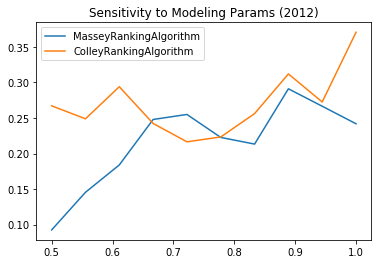

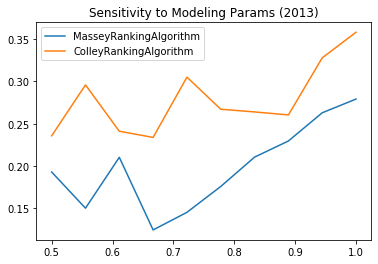

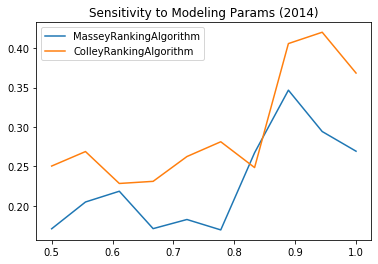

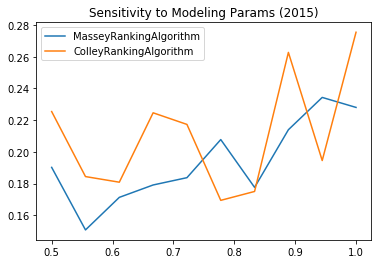

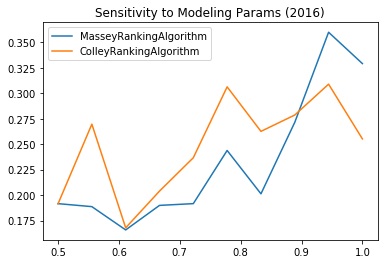

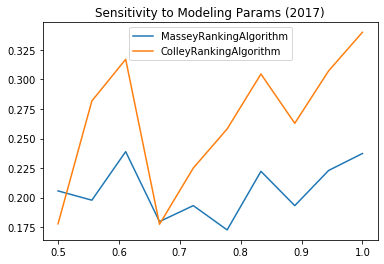

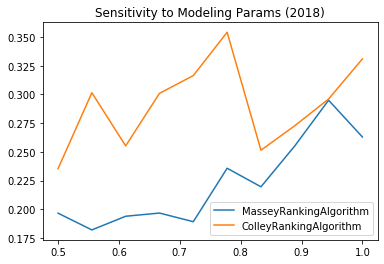

In [12]:
for yr in prev_sensitivity["fp"].unique():
    for method in df["method"].unique():
        data = prev_sensitivity.loc[(prev_sensitivity.fp==yr)&(prev_sensitivity.method==method), ["frac", "w"]]
        plt.plot(data.frac, data.w, label=method)
    plt.title("Sensitivity to Modeling Params ({})".format(yr))
    plt.legend()
    plt.show()